/var/folders/vd/0qb1xmyx4gq8xg7488pl52rh0000gn/T/ipykernel_3821/2837934753.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
/var/folders/vd/0qb1xmyx4gq8xg7488pl52rh0000gn/T/ipykernel_3821/2837934753.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

Unique classes in target variable y: [0. 1.]


/Volumes/BackupPlus/Anaconda/Anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:34:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


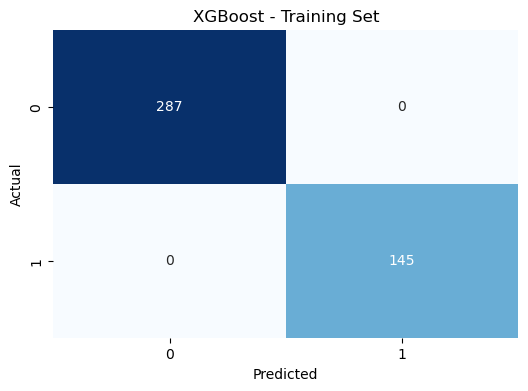

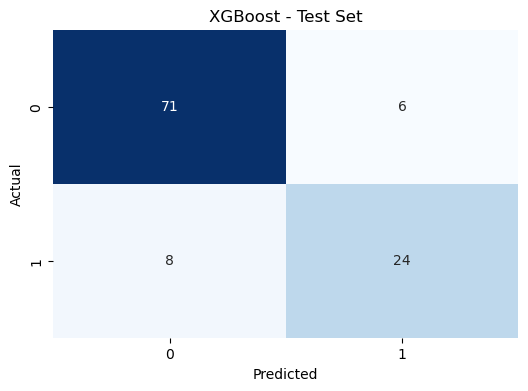

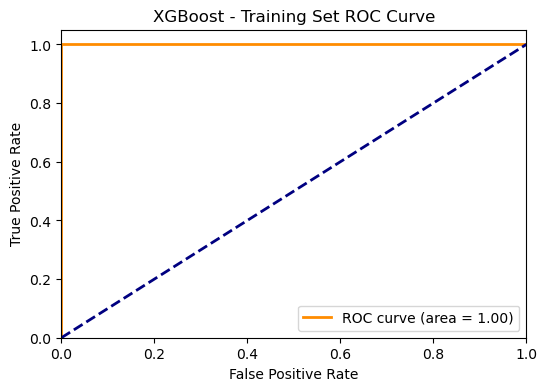

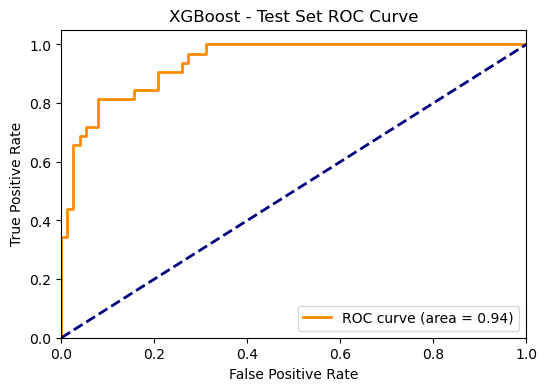

XGBoost - Training Set AUC score: 1.0000
XGBoost - Training Set Precision: 1.0000
XGBoost - Training Set F1 score: 1.0000
XGBoost - Training Set Accuracy: 1.0000
XGBoost - Test Set AUC score: 0.9387
XGBoost - Test Set Precision: 0.8000
XGBoost - Test Set F1 score: 0.7742
XGBoost - Test Set Accuracy: 0.8716


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_excel('/Users/mehtap/Downloads/05.xlsx')

# Calculate the threshold for more than 50% missing values
threshold = len(data.columns) * 0.5

# Identify and remove records with more than 50% missing values
data = data[data.isnull().sum(axis=1) <= threshold]

# Replace missing values with median for numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
for col in numerical_cols:
    data[col].fillna(data[col].median(), inplace=True)

# Identify numerical and categorical columns automatically
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Replace missing values (again, in case any were missed earlier)
for col in numerical_cols:
    data[col].fillna(data[col].median(), inplace=True)
for col in categorical_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Convert all values in categorical columns to string
for col in categorical_cols:
    data[col] = data[col].astype(str)

# Encode categorical columns
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    data[col] = encoders[col].fit_transform(data[col])

# Normalize numerical columns
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Separate features and target variable without dropping any features
X = data.loc[:, data.columns != 'PCOS']  # Select all columns except the target 'PCOS'
y = data['PCOS']

# Check unique classes in y
unique_classes = np.unique(y)
print(f'Unique classes in target variable y: {unique_classes}')

# Check if both classes are present in y
if len(unique_classes) < 2:
    raise ValueError("Target variable has only one class present. Cannot compute metrics.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the XGBoost model with the best parameters
best_params = {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Make predictions on the training and test sets for XGBoost
y_pred_proba_xgb_train = xgb.predict_proba(X_train)[:, 1]
y_pred_xgb_train = xgb.predict(X_train)
y_pred_proba_xgb_test = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_test = xgb.predict(X_test)

# Function to plot confusion matrix (renamed without "heatmap")
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_train, y_pred_xgb_train, 'XGBoost - Training Set')
plot_confusion_matrix(y_test, y_pred_xgb_test, 'XGBoost - Test Set')

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves
plot_roc_curve(y_train, y_pred_proba_xgb_train, 'XGBoost - Training Set ROC Curve')
plot_roc_curve(y_test, y_pred_proba_xgb_test, 'XGBoost - Test Set ROC Curve')

# Calculate and print metrics for XGBoost - Training Set
auc_score_xgb_train = roc_auc_score(y_train, y_pred_proba_xgb_train)
precision_xgb_train = precision_score(y_train, y_pred_xgb_train)
f1_xgb_train = f1_score(y_train, y_pred_xgb_train)
accuracy_xgb_train = accuracy_score(y_train, y_pred_xgb_train)
print(f'XGBoost - Training Set AUC score: {auc_score_xgb_train:.4f}')
print(f'XGBoost - Training Set Precision: {precision_xgb_train:.4f}')
print(f'XGBoost - Training Set F1 score: {f1_xgb_train:.4f}')
print(f'XGBoost - Training Set Accuracy: {accuracy_xgb_train:.4f}')

# Calculate and print metrics for XGBoost - Test Set
auc_score_xgb_test = roc_auc_score(y_test, y_pred_proba_xgb_test)
precision_xgb_test = precision_score(y_test, y_pred_xgb_test)
f1_xgb_test = f1_score(y_test, y_pred_xgb_test)
accuracy_xgb_test = accuracy_score(y_test, y_pred_xgb_test)
print(f'XGBoost - Test Set AUC score: {auc_score_xgb_test:.4f}')
print(f'XGBoost - Test Set Precision: {precision_xgb_test:.4f}')
print(f'XGBoost - Test Set F1 score: {f1_xgb_test:.4f}')
print(f'XGBoost - Test Set Accuracy: {accuracy_xgb_test:.4f}')


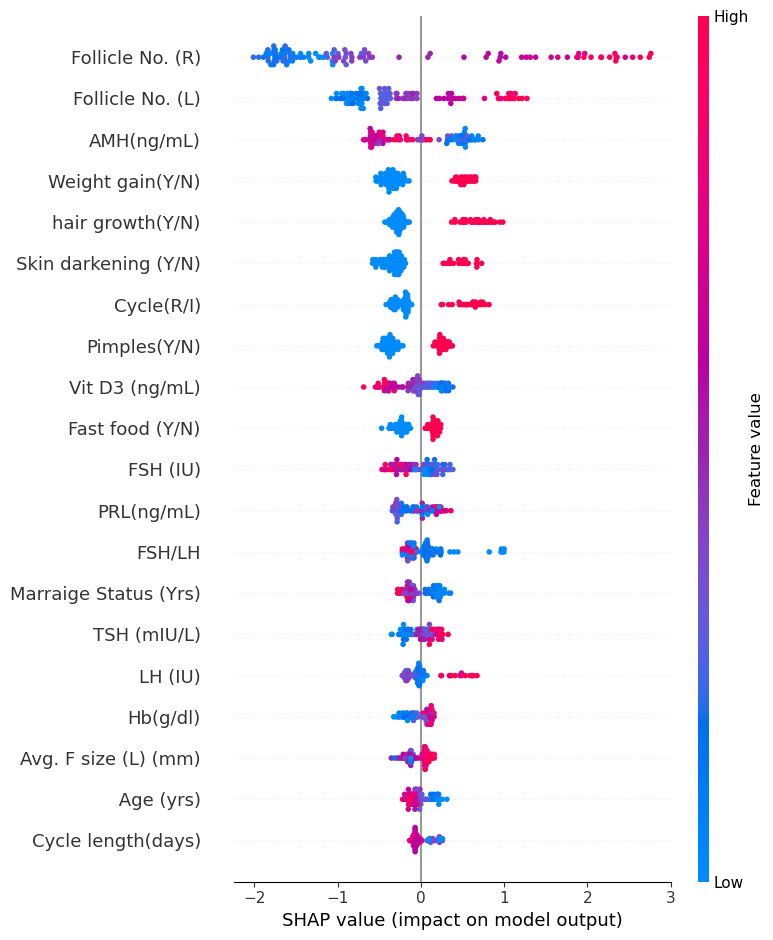

In [4]:
import shap

# Create an explainer object for the XGBoost model
explainer = shap.Explainer(xgb)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


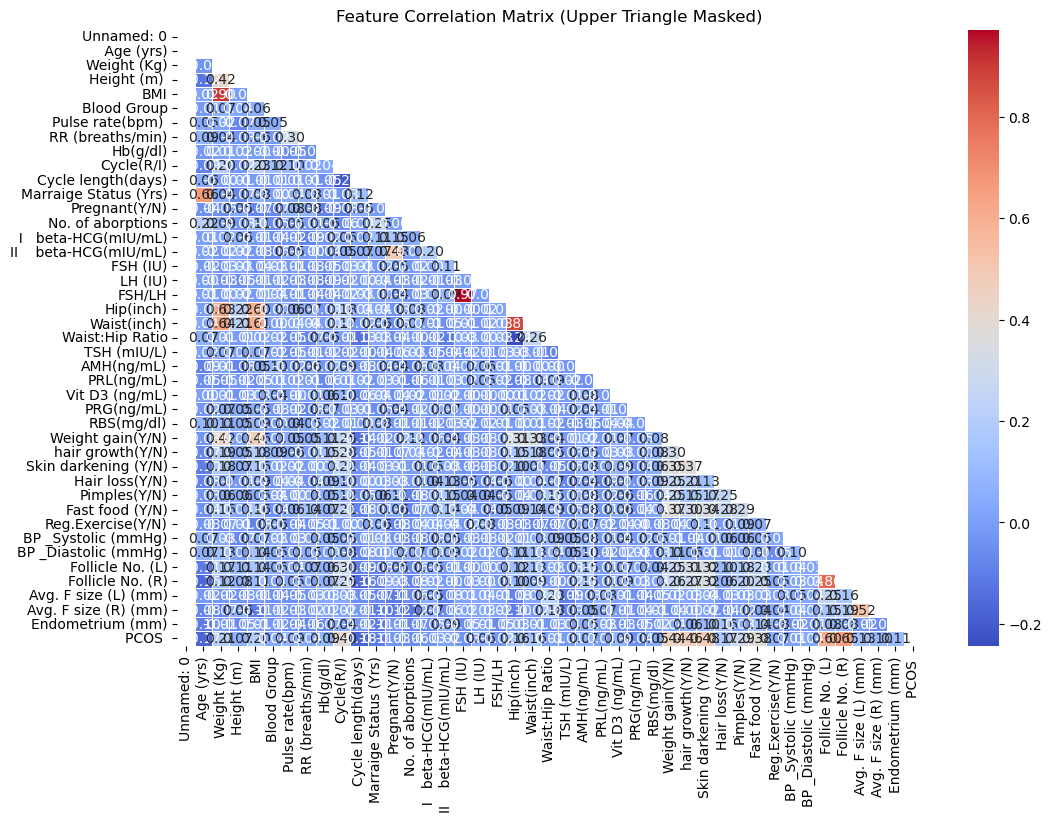

In [12]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Matrix (Upper Triangle Masked)")
plt.show()


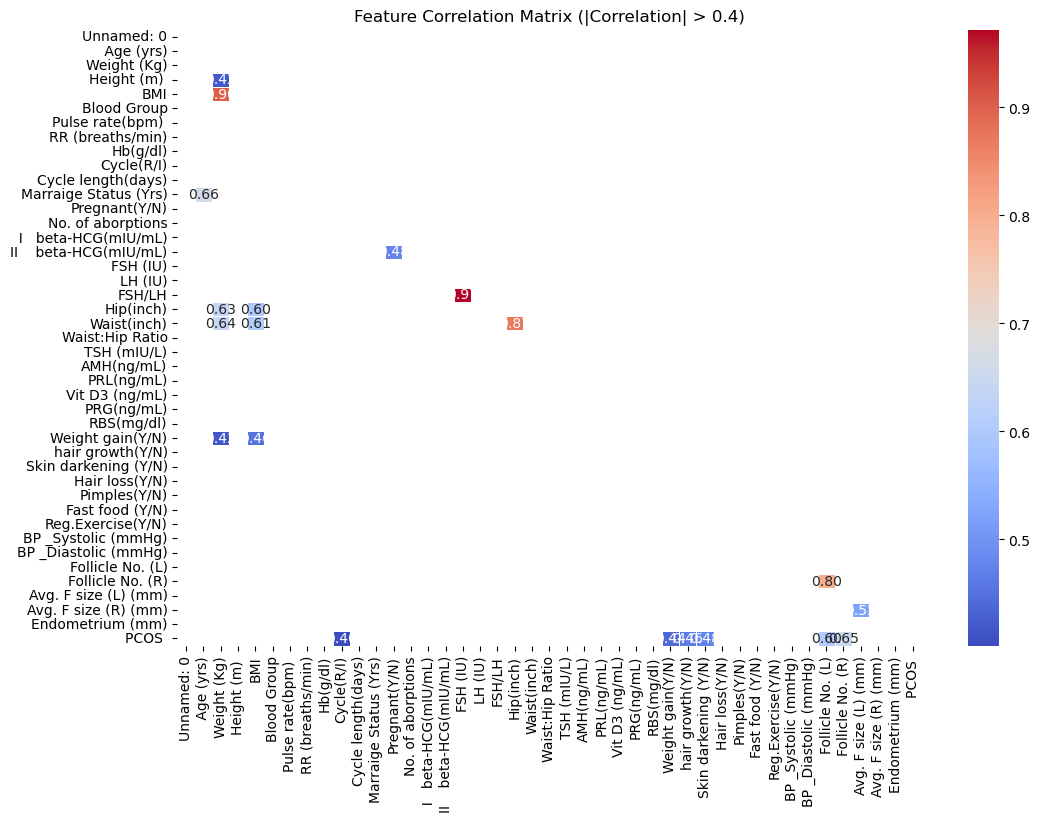

In [16]:
# Set the threshold for displaying significant correlations
threshold = 0.4

# Calculate the correlation matrix
corr_matrix = data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Only keep correlations above the threshold (in absolute value)
filtered_corr = corr_matrix.mask(abs(corr_matrix) < threshold)

# Plot the filtered correlation matrix with the mask
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f"Feature Correlation Matrix (|Correlation| > {threshold})")
plt.show()


In [18]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [24]:
from scipy.stats import ttest_ind, chi2_contingency

# Assuming 'PCOS ' is the target variable (0 = non-PCOS, 1 = PCOS)
pcos_group = data[data['PCOS '] == 1]
nonpcos_group = data[data['PCOS '] == 0]

# Define the demographic continuous variables (e.g., age, BMI, etc.)
continuous_vars = [' Age (yrs)', 'BMI']  # Replace with your actual variable names

# Perform t-tests for continuous variables
for var in continuous_vars:
    t_stat, p_val = ttest_ind(pcos_group[var], nonpcos_group[var], nan_policy='omit')
    print(f'T-test for {var}: p-value = {p_val:.4f}')


T-test for  Age (yrs): p-value = 0.0001
T-test for BMI: p-value = 0.0000


In [26]:
# Define the demographic categorical variables (e.g., sex, ethnicity, etc.)
categorical_vars = ['sex', 'ethnicity']  # Replace with your actual variable names

# Perform chi-square tests for categorical variables
for var in categorical_vars:
    contingency_table = pd.crosstab(data[var], data['PCOS '])
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-square test for {var}: p-value = {p_val:.4f}')


KeyError: 'sex'

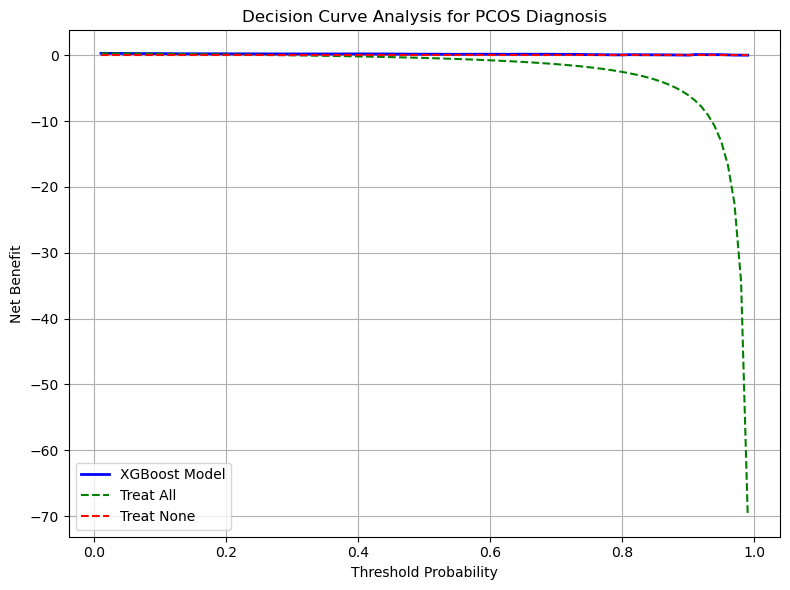

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- Use your actual predictions ---
y_true = y_test  # Your true test labels
y_pred_proba = y_pred_proba_xgb_test  # Your predicted probabilities for class 1 (PCOS)

# --- DCA Calculation ---
def calculate_net_benefit(y_true, y_prob, thresholds):
    n = len(y_true)
    net_benefits = []
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        tp_rate = tp / n
        fp_rate = fp / n
        net_benefit = tp_rate - fp_rate * (threshold / (1 - threshold))
        net_benefits.append(net_benefit)
    return net_benefits

thresholds = np.linspace(0.01, 0.99, 99)
net_benefits = calculate_net_benefit(y_true, y_pred_proba, thresholds)

# --- Treat All and Treat None Baselines ---
event_rate = np.mean(y_true)
treat_all = [event_rate - (1 - event_rate) * (t / (1 - t)) for t in thresholds]
treat_none = [0] * len(thresholds)

# --- Plot the DCA ---
plt.figure(figsize=(8, 6))
plt.plot(thresholds, net_benefits, label="XGBoost Model", color="blue", linewidth=2)
plt.plot(thresholds, treat_all, label="Treat All", linestyle="--", color="green")
plt.plot(thresholds, treat_none, label="Treat None", linestyle="--", color="red")
plt.xlabel("Threshold Probability")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis for PCOS Diagnosis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
